<a href="https://colab.research.google.com/github/soy-min/climate-prognosis/blob/main/ClimatePrognosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import callbacks
import os
import pickle

Globale Parameter

In [41]:
__START_YEAR_OBSERVATION='1990-01-01'
__OBSERVATION_LOCATION_NAME='DEFAULT'
__GLOBAL_PRINTOUTS=False
__PREDICTION_PERIOD=60 #Months
__LOOKBACK_PERIOD=4*__PREDICTION_PERIOD #Months
__MAX_EPOCHS = 100
__MA_WINDOW=12
__WIDTH_SIZE=10
__HEIGHT_SIZE=6

CSV laden

In [42]:
# Laden der CSV-Datei
#df = pd.read_csv('SW000002361.csv')
#df = pd.read_csv('USC00122825.csv')
url="https://www.ncei.noaa.gov/data/global-summary-of-the-month/access/"
file="USW00012836.csv" 
# Gemäßigt:
#SEATTLE SAND POINT WEATHER FORECAST OFFICE, WA US (USW00094290.csv)
# Tropen:
#KEY WEST INTERNATIONAL AIRPORT, FL US (USW00012836.csv)

if os.path.exists(file+".pickle"):
  df = pd.read_pickle(file+".pickle")  
else:
  df = pd.read_csv(url+file)
df.to_pickle(file+".pickle")

__OBSERVATION_LOCATION_NAME=df.iloc[1]['NAME']

if __GLOBAL_PRINTOUTS: print(df.head())

Reduzieren auf relevante Informationen

In [43]:
# Auswahl der relevanten Spalten (z.B. Datum, Temperatur)
df = df[['DATE', 'TMAX','TMIN']]
# Umbenennen der Spalten
df = df.rename(columns={'DATE': 'date', 'TMAX': 'temp_min','TMIN': 'temp_max'})
# Festlegen des Indexes als Datum
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
# NANs interpolieren
df=df.interpolate()
df['MA_min'] = df['temp_min'].rolling(window=__MA_WINDOW).mean()
df['MA_max'] = df['temp_max'].rolling(window=__MA_WINDOW).mean()

# reduzieren auf > __START_YEAR_OBSERVATION
df=df.loc[__START_YEAR_OBSERVATION:]
# einblick in die Daten
if __GLOBAL_PRINTOUTS:df

#TODO:
#- Sicherstellen, dass Daten vollständig verfügbar sind (keine NANs am Anfang)

Visualisieren der Daten

<Figure size 640x480 with 0 Axes>

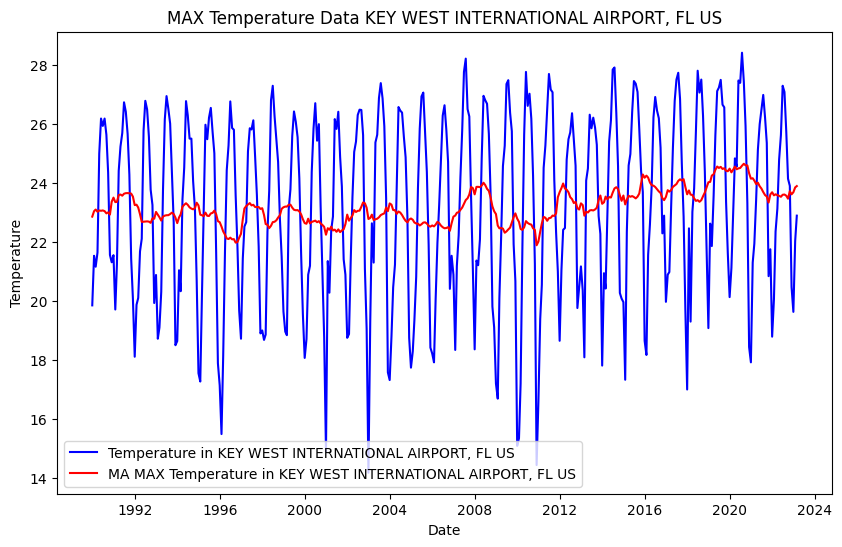

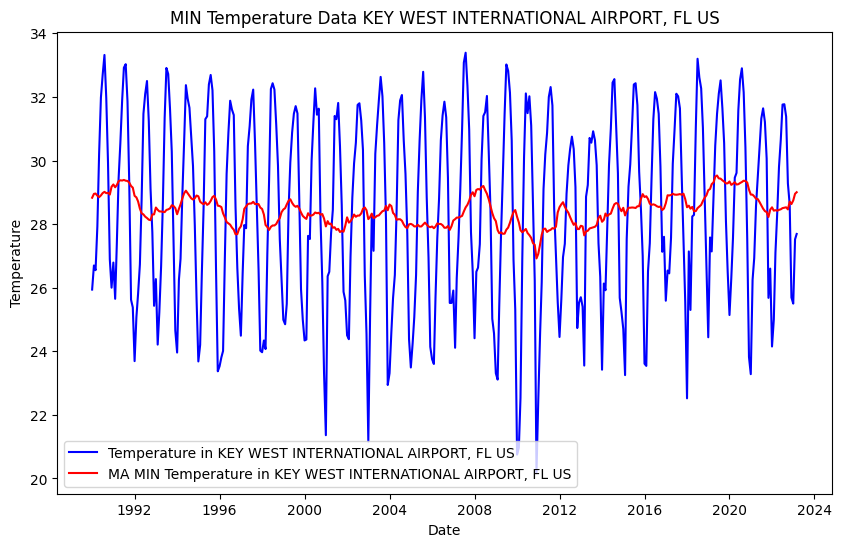

In [44]:
# Plotten der Ergebnisse
plt.figure(0)
plt.figure(figsize=(__WIDTH_SIZE,__HEIGHT_SIZE))
plt.plot(df.index, df['temp_max'], color='blue', label='Temperature in '+__OBSERVATION_LOCATION_NAME)
plt.plot(df.index, df['MA_max'], color='red', label='MA MAX Temperature in '+__OBSERVATION_LOCATION_NAME)
plt.title('MAX Temperature Data '+__OBSERVATION_LOCATION_NAME)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.figure(1)
plt.figure(figsize=(__WIDTH_SIZE,__HEIGHT_SIZE))
plt.plot(df.index, df['temp_min'], color='blue', label='Temperature in '+__OBSERVATION_LOCATION_NAME)
plt.plot(df.index, df['MA_min'], color='red', label='MA MIN Temperature in '+__OBSERVATION_LOCATION_NAME)
plt.title('MIN Temperature Data '+__OBSERVATION_LOCATION_NAME)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

Trainings und Testdaten separieren

In [45]:
# Teilen der Daten in Trainings- und Testdaten
train_min, test_min = train_test_split(df[["MA_min"]], test_size=0.3, shuffle=False)
train_max, test_max = train_test_split(df[["MA_max"]], test_size=0.3, shuffle=False)
# Ergebnis einsehen
if __GLOBAL_PRINTOUTS:test_min

<Figure size 640x480 with 0 Axes>

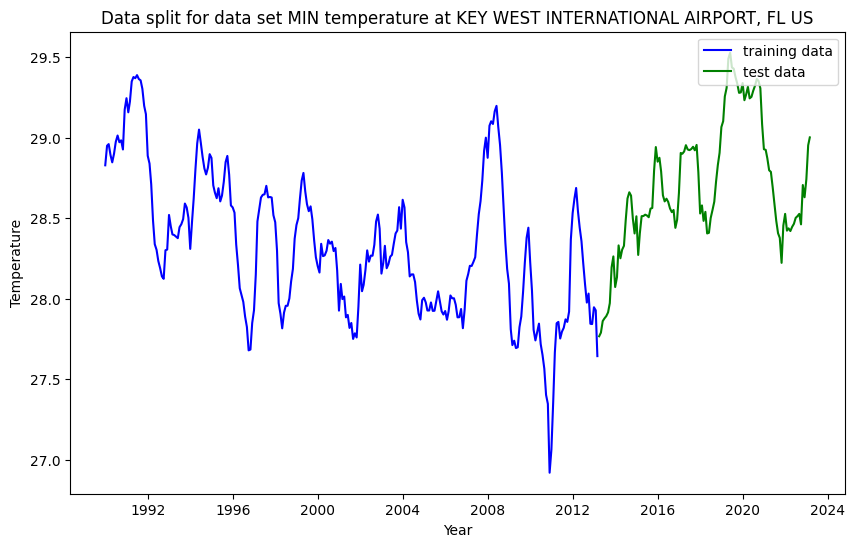

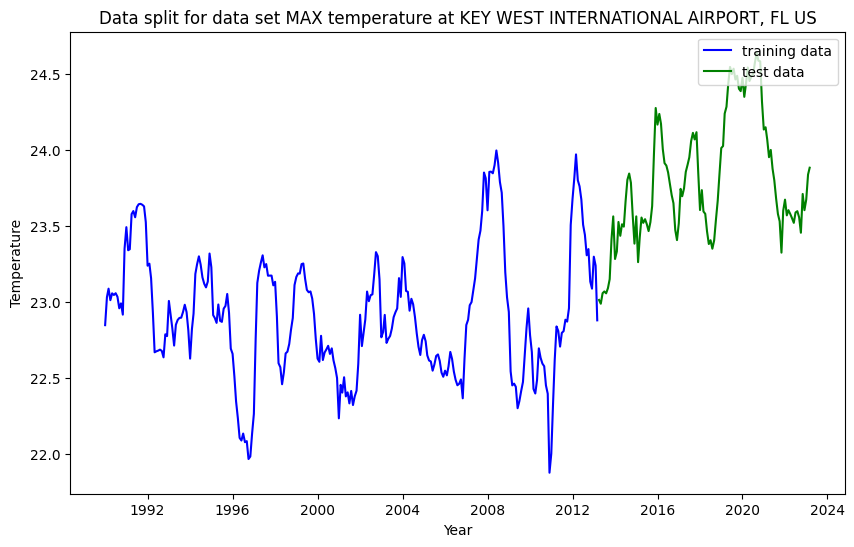

In [55]:
def plotTestTrainData(train, test,prefix,plot_id):
  # plot train and validation loss
  plt.figure(plot_id)
  plt.figure(figsize=(__WIDTH_SIZE,__HEIGHT_SIZE))
  plt.plot(train, color='blue')
  plt.plot(test, color='green')
  plt.title('Data split for data set '+prefix+' temperature at '+__OBSERVATION_LOCATION_NAME)
  plt.ylabel('Temperature')
  plt.xlabel('Year')
  plt.legend(['training data', 'test data'], loc='upper right')

plotTestTrainData(train_min,test_min, "MIN", 0)
plotTestTrainData(train_max,test_max, "MAX", 1)

plt.show()

Normierung auf Werte 0..1

In [46]:
# Skalieren der Daten
scaler_min = MinMaxScaler()
all_scaled_min=scaler_min.fit_transform(df[["MA_min"]])
train_scaled_min = scaler_min.fit_transform(train_min)
test_scaled_min = scaler_min.transform(test_min)

scaler_max = MinMaxScaler()
all_scaled_max=scaler_max.fit_transform(df[["MA_max"]])
train_scaled_max = scaler_max.fit_transform(train_max)
test_scaled_max = scaler_max.transform(test_max)
# Ergebnis einsehen
if __GLOBAL_PRINTOUTS:test_scaled_max

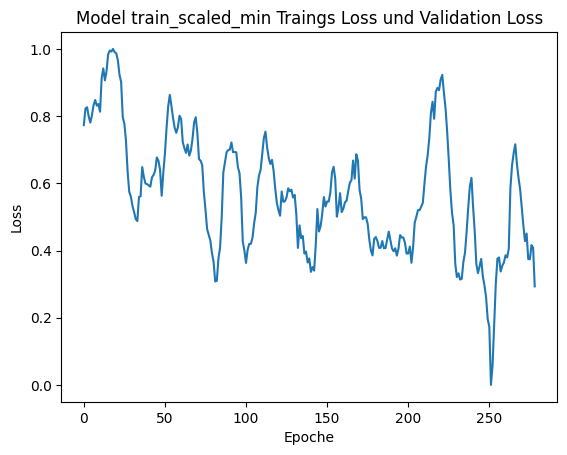

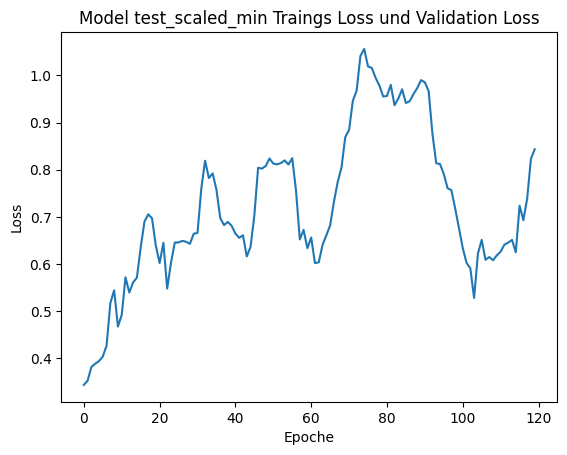

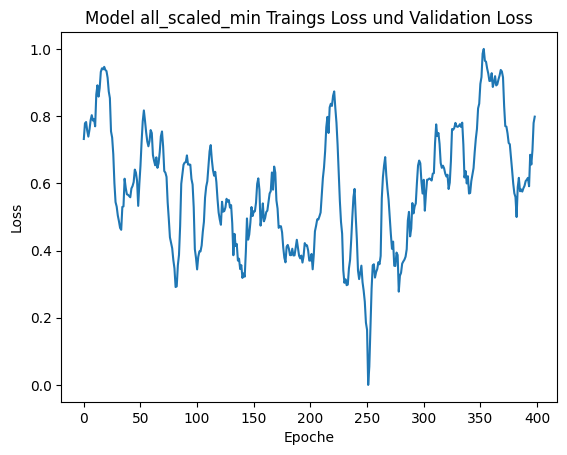

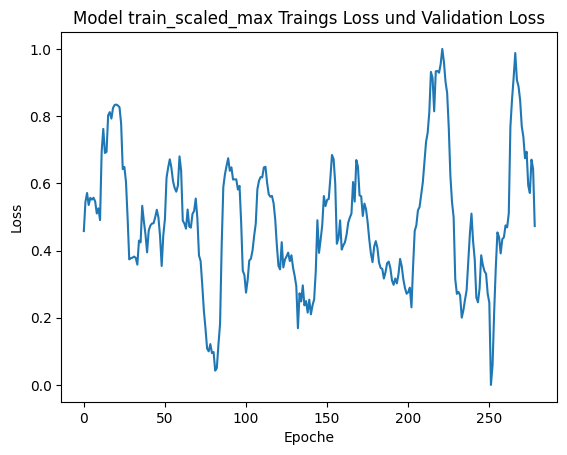

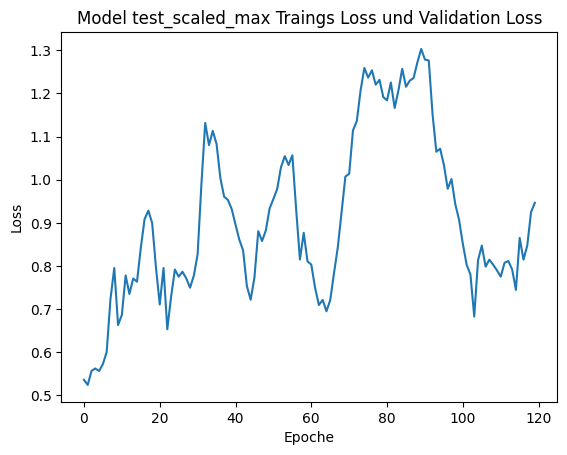

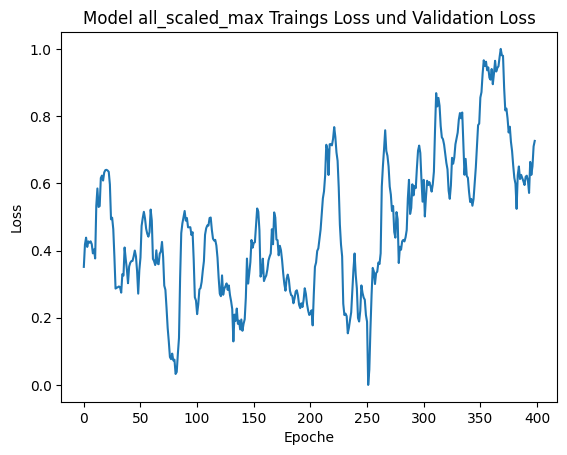

In [47]:
def plotHistory(model,prefix,plot_id):
  # plot train and validation loss
  plt.figure(plot_id)
  plt.plot(model)
  plt.title('Model '+prefix+' Traings Loss und Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoche')

plotHistory(train_scaled_min, "train_scaled_min", 0)
plotHistory(test_scaled_min, "test_scaled_min", 2)
plotHistory(all_scaled_min, "all_scaled_min", 4)
plotHistory(train_scaled_max, "train_scaled_max", 1)
plotHistory(test_scaled_max, "test_scaled_max", 3)
plotHistory(all_scaled_max, "all_scaled_max", 5)

plt.show()

In [48]:


# Vorbereiten der Trainingsdaten
look_back = __LOOKBACK_PERIOD # Anzahl der vorherigen Monate, die zur Vorhersage verwendet werden
def fitModel(training_data, all_data):
  X_train = []
  y_train = []
  X_validate=[]
  y_validate=[]
  for i in range(look_back, len(training_data)):
      X_train.append(training_data[i-look_back:i, 0])
      y_train.append(training_data[i, 0])
  X_train, y_train = np.array(X_train), np.array(y_train)

  for i in range(len(training_data),len(all_data)):
      X_validate.append(all_data[i-look_back:i, 0])
      y_validate.append(all_data[i, 0])
  X_validate, y_validate = np.array(X_validate), np.array(y_validate)

  # Umformen der Daten in das erforderliche 3D-Array-Format
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  X_validate = np.reshape(X_validate, (X_validate.shape[0], X_validate.shape[1], 1))

  #earlystopping mechanismus
  earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=10,
                                        restore_best_weights=True)


  # Definieren und Trainieren des LSTM-Modells
  model = Sequential()
  model.add(LSTM(units=look_back, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  model.add(LSTM(units=look_back))
  model.add(Dense(units=1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  history=model.fit(X_train, y_train, epochs=__MAX_EPOCHS, batch_size=32, validation_data=(X_validate, y_validate),callbacks=[earlystopping])


  return model,history

model_min,model_min_history=fitModel(train_scaled_min,all_scaled_min)
model_max,model_max_history=fitModel(train_scaled_max,all_scaled_max)




Epoch 1/100
2/2 [==============================] - 11s 4s/step - loss: 0.1839 - val_loss: 0.0173
Epoch 2/100
2/2 [==============================] - 7s 5s/step - loss: 0.0481 - val_loss: 0.0192
Epoch 3/100
2/2 [==============================] - 5s 3s/step - loss: 0.0309 - val_loss: 0.0890
Epoch 4/100
2/2 [==============================] - 6s 4s/step - loss: 0.0403 - val_loss: 0.0849
Epoch 5/100
2/2 [==============================] - 5s 3s/step - loss: 0.0359 - val_loss: 0.0445
Epoch 6/100
2/2 [==============================] - 5s 3s/step - loss: 0.0250 - val_loss: 0.0166
Epoch 7/100
2/2 [==============================] - 6s 3s/step - loss: 0.0220 - val_loss: 0.0087
Epoch 8/100
2/2 [==============================] - 5s 3s/step - loss: 0.0275 - val_loss: 0.0094
Epoch 9/100
2/2 [==============================] - 6s 5s/step - loss: 0.0241 - val_loss: 0.0234
Epoch 10/100
2/2 [==============================] - 5s 3s/step - loss: 0.0201 - val_loss: 0.0417
Epoch 11/100
2/2 [====================

Plot Fitting History

<Figure size 640x480 with 0 Axes>

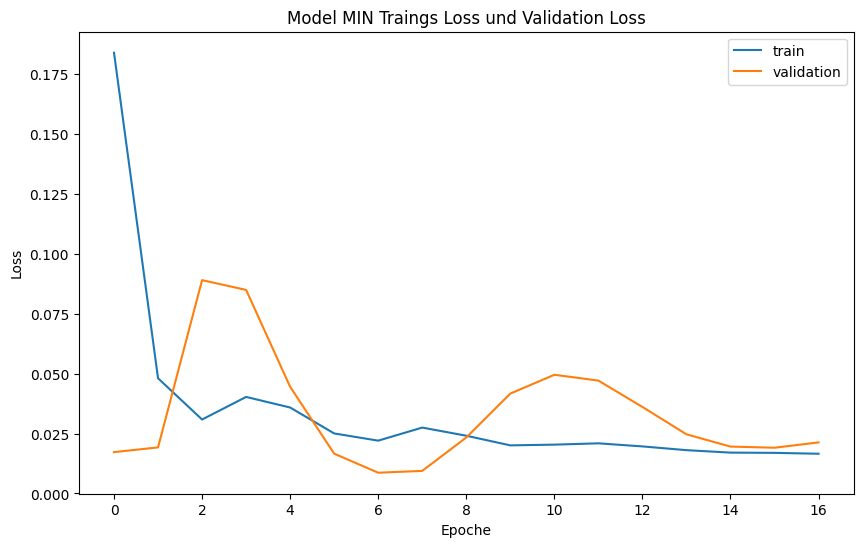

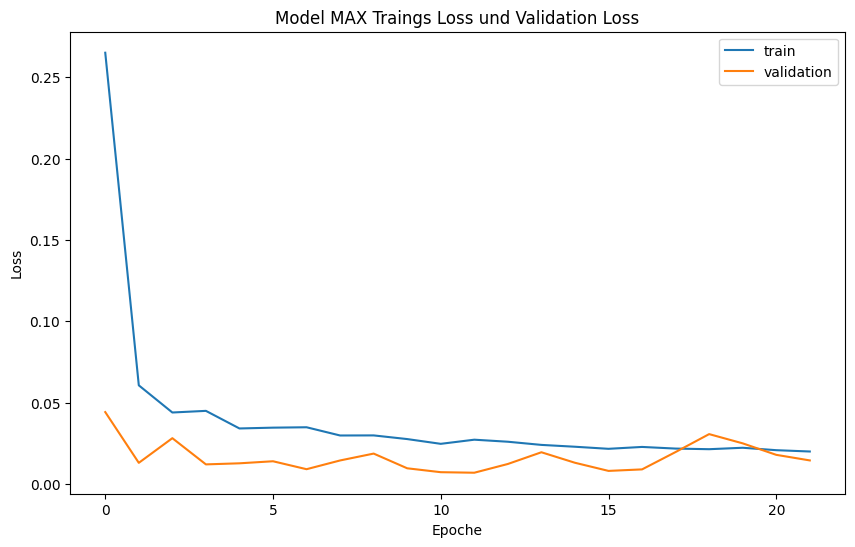

In [49]:
def plotHistory(model,prefix,plot_id):
  # plot train and validation loss
  plt.figure(plot_id)
  plt.figure(figsize=(__WIDTH_SIZE,__HEIGHT_SIZE))
  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('Model '+prefix+' Traings Loss und Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoche')
  plt.legend(['train', 'validation'], loc='upper right')

plotHistory(model_min_history, "MIN", 0)
plotHistory(model_max_history, "MAX", 1)

plt.show()

Modell Validieren

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


4/4 [==============================] - 5s 987ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


4/4 [==============================] - 4s 823ms/step


<Figure size 640x480 with 0 Axes>

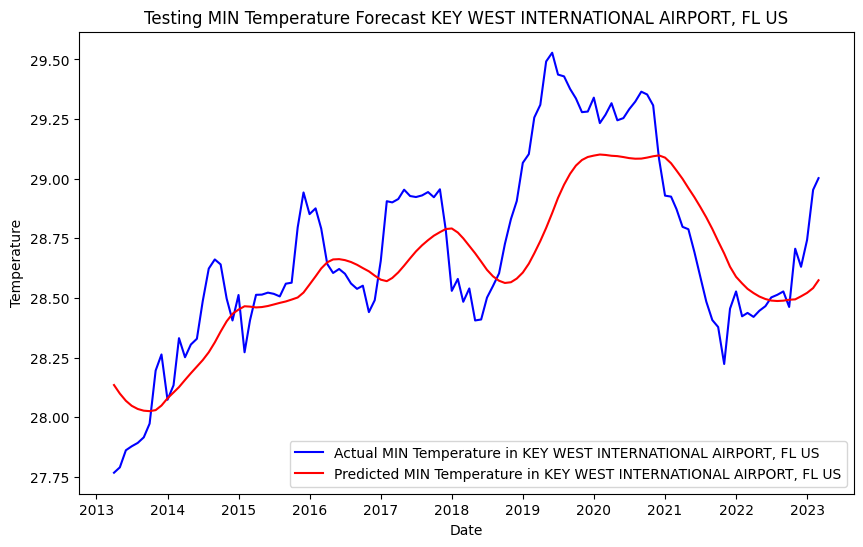

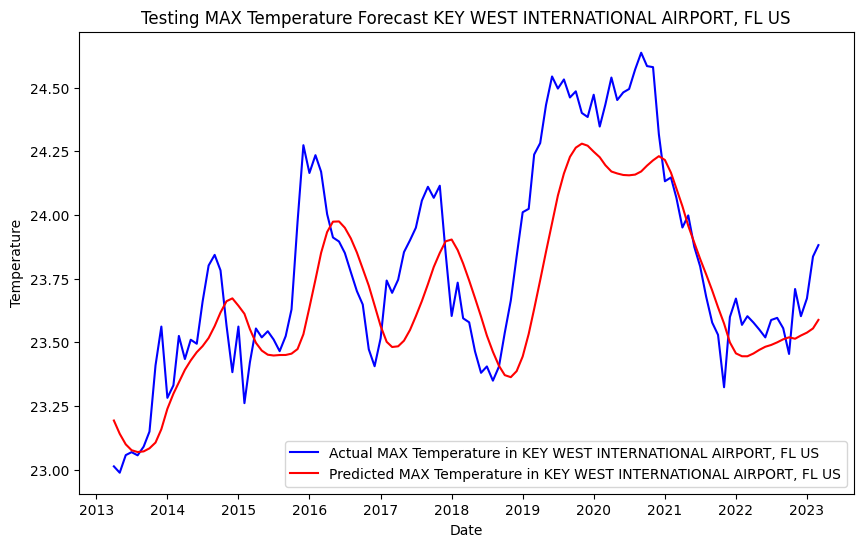

In [50]:
# Vorbereiten der Testdaten
anus=None

def prepareAndPlot(model,df,testdata, prefix, plot_id,scaler):
  inputs = df[len(df) - len(testdata) - look_back:].values
  inputs = scaler.transform(inputs)
  X_test = []
  for i in range(look_back, len(inputs)):
      X_test.append(inputs[i-look_back:i, 0])
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  # Vorhersage der Temperaturen
  predicted = model.predict(X_test)
  predicted = scaler.inverse_transform(predicted)

  # Plotten der Ergebnisse
  plt.figure(plot_id)
  plt.figure(figsize=(__WIDTH_SIZE,__HEIGHT_SIZE))
  plt.plot(testdata.index, testdata.iloc[:,0], color='blue', label='Actual '+prefix+' Temperature in '+__OBSERVATION_LOCATION_NAME)
  plt.plot(testdata.index, predicted, color='red', label='Predicted '+prefix+' Temperature in '+__OBSERVATION_LOCATION_NAME)
  plt.title('Testing '+prefix+' Temperature Forecast '+__OBSERVATION_LOCATION_NAME)
  plt.xlabel('Date')
  plt.ylabel('Temperature')
  plt.legend()

prepareAndPlot(model_min,df[["MA_min"]],test_min,"MIN",0,scaler_min)
prepareAndPlot(model_max,df[["MA_max"]],test_max,"MAX",1,scaler_max)


plt.show()

Prognose auf Zukunft anwenden

In [51]:
def calculateResults(df,model,scaler):
  df_future=df[-look_back:]
  prediction_period=__PREDICTION_PERIOD #months
  results = np.zeros(shape=(prediction_period, 1))
  lower_conf = np.zeros(shape=(prediction_period, 1))
  upper_conf = np.zeros(shape=(prediction_period, 1))
  last_known_dateindex=df_future.iloc[[-1]].index

  for i in range(0,prediction_period):
    F_test = []
    inputs=scaler.transform(df_future[-look_back:].values)
    F_test.append(inputs)
    F_test= np.array(F_test)
    F_test = np.reshape(F_test, (F_test.shape[0], F_test.shape[1], 1))
    # Vorhersage der Temperaturen n=1
    predicted = model.predict(F_test)
    predicted = scaler.inverse_transform(predicted)

    predicted
    results[i]=predicted

    # add predicted element to df_future
    next_date = last_known_dateindex + pd.DateOffset(months=i+1)
    df_future=pd.concat([df_future,pd.DataFrame({ df_future.columns[0]:predicted[0]}, index=next_date)])
  
  

  if __GLOBAL_PRINTOUTS: results
  return df_future

df_future_min=calculateResults(df[["MA_min"]], model_min,scaler_min)
df_future_max=calculateResults(df[["MA_max"]], model_max,scaler_max)

1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 91ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 89ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 134ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 145ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 124ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 122ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 83ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 85ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 94ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 88ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 84ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 103ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 85ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 95ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 88ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 94ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 92ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 84ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 90ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 97ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 109ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 89ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 88ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 92ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 99ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 96ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 89ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 869ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 319ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 132ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 132ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 336ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 164ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 162ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 193ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 95ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 92ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 94ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 86ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 102ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 98ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 84ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 91ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 93ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 105ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 96ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 897ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 95ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 86ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 95ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 948ms/step


<Figure size 640x480 with 0 Axes>

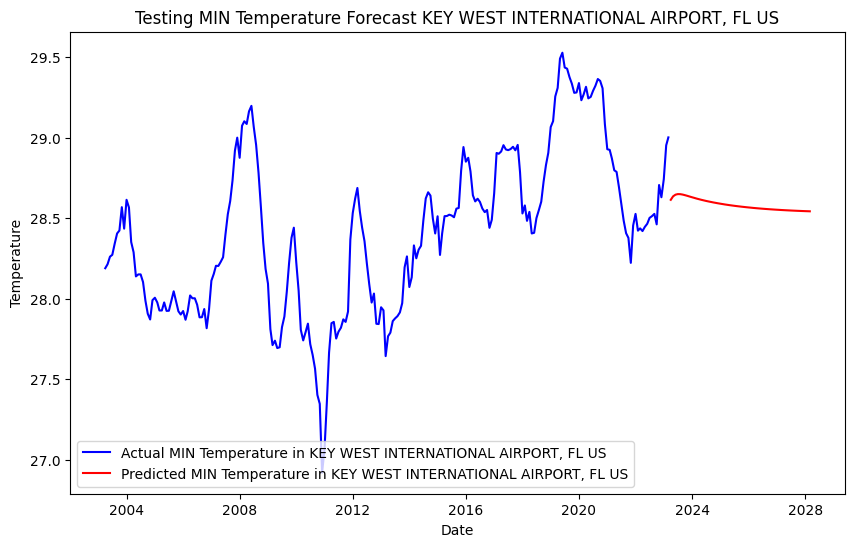

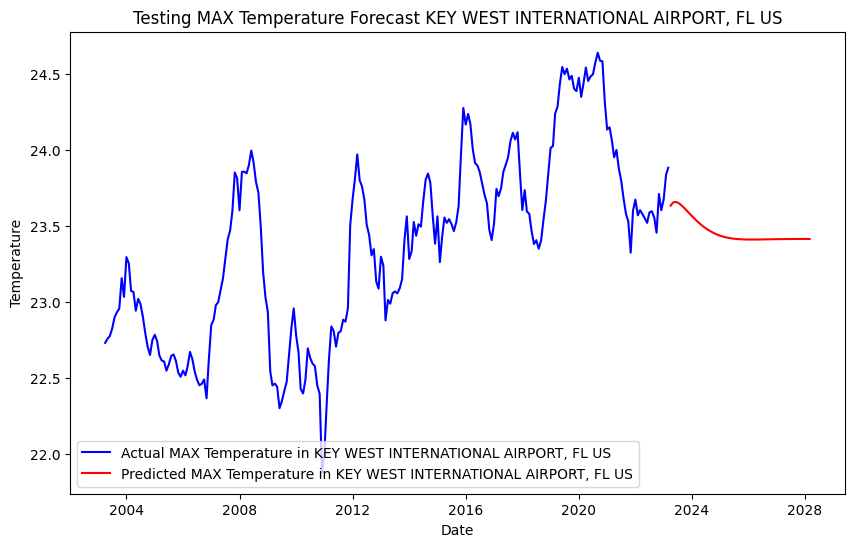

In [52]:


# Plotten der Ergebnisse
def plotResults(df_future, prefix, plot_id):
  plt.figure(plot_id)
  plt.figure(figsize=(__WIDTH_SIZE,__HEIGHT_SIZE))
  plt.plot(df_future[:look_back].index, df_future[:look_back], color='blue', label='Actual '+prefix+' Temperature in '+__OBSERVATION_LOCATION_NAME)
  plt.plot(df_future[look_back:].index, df_future[look_back:], color='red', label='Predicted '+prefix+' Temperature in '+__OBSERVATION_LOCATION_NAME)
  plt.title('Testing '+prefix+' Temperature Forecast '+__OBSERVATION_LOCATION_NAME)
  plt.xlabel('Date')
  plt.ylabel('Temperature')
  plt.legend()

plotResults(df_future_min,"MIN",0)
plotResults(df_future_max,"MAX",1)


plt.show()